# Capstone for Coursera's IBM professional certificate in data science
### Week 3 Project
The goal of this project is to use k-means clustering to define neighborhoods in Toronto

In [4]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup

#mapping tools 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import folium # map rendering library

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

## Scrape Wikipedia with BeautifulSoup

In [5]:
# read csv file
geo = pd.read_csv('https://cocl.us/Geospatial_data') 
# examine the shape of original input data
print(geo.shape)
geo.head()

(103, 3)


,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [6]:
# create an object with raw data from website
website_url = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M").text

In [7]:
# create an object with the data from the website
bs = BeautifulSoup(website_url)

In [8]:
# search for table
tbl = bs.find('table',{'class':'wikitable sortable'})
#tbl

In [9]:
# clean data
rows = []
for row in tbl.find_all("tr"):
    cols = row.find_all("td")
    cols = [idx.text.strip() for idx in cols]
    rows.append(cols)

rows[0:5]

[[],
 ['M1A', 'Not assigned', 'Not assigned'],
 ['M2A', 'Not assigned', 'Not assigned'],
 ['M3A', 'North York', 'Parkwoods'],
 ['M4A', 'North York', 'Victoria Village']]

In [10]:
# remove empty indices
rows.remove([])

In [11]:
rows[0:5]

[['M1A', 'Not assigned', 'Not assigned'],
 ['M2A', 'Not assigned', 'Not assigned'],
 ['M3A', 'North York', 'Parkwoods'],
 ['M4A', 'North York', 'Victoria Village'],
 ['M5A', 'Downtown Toronto', 'Harbourfront']]

## Build initial dataframe

In [12]:
#create initial pd DataFrame
df = pd.DataFrame(rows)
df = df.rename(columns={0:"Postcode",1:"Borough",2:"Neighborhood"})
df.head()

,Postcode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


In [13]:
df[df['Borough']!='Not assigned'].head()

,Postcode,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M5A,Downtown Toronto,Regent Park
6,M6A,North York,Lawrence Heights


In [14]:
#drop rows where 'Bourough' = 'Not assigned'
df = df[df['Borough']!='Not assigned'].reset_index(drop=True)
df.head()

,Postcode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M5A,Downtown Toronto,Regent Park
4,M6A,North York,Lawrence Heights


In [15]:
df['Neighborhood'] = np.where(
    df['Neighborhood']=='Not assigned',
    df['Borough'],
    df['Neighborhood']
)
df.head()

,Postcode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M5A,Downtown Toronto,Regent Park
4,M6A,North York,Lawrence Heights


In [16]:
# df = (df.groupby(['Postcode','Borough'])['Neighborhood']
#        .apply(lambda x: ','.join(set(x.dropna())))
#        .reset_index())

# df = pd.DataFrame(df)
# df.head()

In [17]:
df = df.join(geo.set_index('Postal Code'), how='outer', on='Postcode')
df.head()

,Postcode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
3,M5A,Downtown Toronto,Regent Park,43.654260,-79.360636
4,M6A,North York,Lawrence Heights,43.718518,-79.464763


# Mapping

In [18]:
import json
import requests
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

In [19]:
address = 'Toronto, Ontario'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto, Canada are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto, Canada are 43.653963, -79.387207.


In [23]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=13)

# add markers to map
for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighborhood']):
    label = '{},{}'.format(neighborhood,borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_toronto) 

map_toronto

**Setup FourSquare API**

In [25]:
# from https://foursquare.com/developers/apps
CLIENT_ID = 'your_id_here' # my Foursquare ID
CLIENT_SECRET = 'your_secret_here' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [30]:
#define objects for 'Regent Park'
neighborhood = 'Regent Park'
idx = pd.Index(df['Neighborhood']).get_loc(neighborhood)

neighborhood_latitude =  df.loc[idx,'Latitude'] # neighborhood latitude value
neighborhood_longitude = df.loc[idx,'Longitude'] # neighborhood longitude value

print('Latitude and longitude values of ', neighborhood, 'are {}, {}.'
      .format(neighborhood_latitude, 
              neighborhood_longitude))

Latitude and longitude values of  Regent Park are 43.6542599, -79.3606359.


In [32]:
#step 1 - create the correct GET request URL
radius = 500
LIMIT = 100

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)

**Pull Data**

In [33]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5cbb2e54351e3d3ef7f641e9'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Corktown',
  'headerFullLocation': 'Corktown, Toronto',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 48,
  'suggestedBounds': {'ne': {'lat': 43.6587599045, 'lng': -79.3544279001486},
   'sw': {'lat': 43.6497598955, 'lng': -79.36684389985142}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '54ea41ad498e9a11e9e13308',
       'name': 'Roselle Desserts',
       'location': {'address': '362 King St E',
        'crossStreet': 'Trinity St',
        'lat': 43.653446723052674,
        'lng': -79.3620167174383,
        'labeledLatLngs': [{'label': 'display',
 

In [34]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [35]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Roselle Desserts,Bakery,43.653447,-79.362017
1,Tandem Coffee,Coffee Shop,43.653559,-79.361809
2,Toronto Cooper Koo Family Cherry St YMCA Centre,Gym / Fitness Center,43.653191,-79.357947
3,Morning Glory Cafe,Breakfast Spot,43.653947,-79.361149
4,Body Blitz Spa East,Spa,43.654735,-79.359874


In [36]:
map_venues = folium.Map(location=[neighborhood_latitude, neighborhood_longitude], zoom_start=17)

# add markers to map
for lat, lng, name, categories in zip(nearby_venues['lat'], nearby_venues['lng'], nearby_venues['name'], nearby_venues['categories']):
    label = '{},{}'.format(categories,name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_venues) 
    
map_venues

# Clustering

**Aggregate Data**

In [38]:
# create a function to get all venues for each neighborhood
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        # print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [40]:
#run function for all toronto neighborhoods and create df 'toronto_venues'
toronto_venues = getNearbyVenues(names=df['Neighborhood'],
                                 latitudes=df['Latitude'],
                                 longitudes=df['Longitude']
                                 )

In [41]:
toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,KFC,43.754387,-79.333021,Fast Food Restaurant
2,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
3,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
4,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop


In [42]:
print(toronto_venues.groupby('Neighborhood').count().shape)
toronto_venues.groupby('Neighborhood').count().head()

(205, 6)


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Adelaide,100,100,100,100,100,100
Agincourt,4,4,4,4,4,4
Agincourt North,2,2,2,2,2,2
Albion Gardens,8,8,8,8,8,8
Alderwood,9,9,9,9,9,9


## Analyze Neighborhoods

In [43]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()

print(toronto_grouped.shape)
toronto_grouped.head()

(205, 280)


,Neighborhood,Yoga Studio,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,...,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,Adelaide,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.01,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0
1,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
2,Agincourt North,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
3,Albion Gardens,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
4,Alderwood,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0


In [44]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [101]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adelaide,Coffee Shop,Café,Steakhouse,Thai Restaurant,American Restaurant,Restaurant,Asian Restaurant,Sushi Restaurant,Bakery,Burger Joint
1,Agincourt,Breakfast Spot,Lounge,Clothing Store,Skating Rink,Doner Restaurant,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run
2,Agincourt North,Park,Playground,Dive Bar,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run
3,Albion Gardens,Grocery Store,Sandwich Place,Beer Store,Fast Food Restaurant,Fried Chicken Joint,Pharmacy,Pizza Place,College Stadium,Colombian Restaurant,Dumpling Restaurant
4,Alderwood,Pizza Place,Gym,Coffee Shop,Skating Rink,Pharmacy,Pub,Sandwich Place,Pool,Women's Store,Dim Sum Restaurant


## Cluster Neighborhoods

In [ ]:
toronto_grouped_clustering = toronto_grouped.drop(columns=['Neighborhood'])

Text(0.5, 1.0, 'The Elbow Method showing the optimal k')

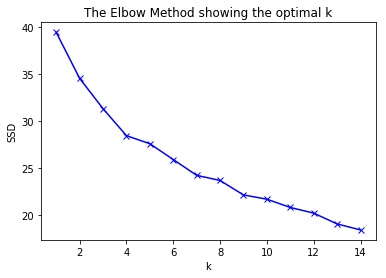

In [98]:
import matplotlib.pyplot as plt
%matplotlib inline

# k means determine k
ssd = []
K = range(1,15)
for k in K:
    kmeans = KMeans(n_clusters=k, 
                    init='random',
                    n_init=100,
                    max_iter=1000,
                    random_state=409
                   )
    kmeans.fit(toronto_grouped_clustering)
    ssd.append(kmeans.inertia_)

# Plot the elbow
plt.plot(K, ssd, 'bx-')
plt.xlabel('k')
plt.ylabel('SSD')
plt.title('The Elbow Method showing the optimal k')

In [99]:
# optimal k from above is 4
kclusters = 4

toronto_grouped_clustering = toronto_grouped.drop(columns=['Neighborhood'])

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [102]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
neighborhoods_venues_sorted.head()

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,Adelaide,Coffee Shop,Café,Steakhouse,Thai Restaurant,American Restaurant,Restaurant,Asian Restaurant,Sushi Restaurant,Bakery,Burger Joint
1,0,Agincourt,Breakfast Spot,Lounge,Clothing Store,Skating Rink,Doner Restaurant,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run
2,1,Agincourt North,Park,Playground,Dive Bar,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run
3,0,Albion Gardens,Grocery Store,Sandwich Place,Beer Store,Fast Food Restaurant,Fried Chicken Joint,Pharmacy,Pizza Place,College Stadium,Colombian Restaurant,Dumpling Restaurant
4,0,Alderwood,Pizza Place,Gym,Coffee Shop,Skating Rink,Pharmacy,Pub,Sandwich Place,Pool,Women's Store,Dim Sum Restaurant


In [103]:
toronto_merged = df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), how='inner', on='Neighborhood')

toronto_merged # check the last columns!

,Postcode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,43.753259,-79.329656,1,Park,Fast Food Restaurant,Food & Drink Shop,Women's Store,Dog Run,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar
1,M4A,North York,Victoria Village,43.725882,-79.315572,0,Portuguese Restaurant,Coffee Shop,Hockey Arena,Intersection,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop,Doner Restaurant,Deli / Bodega
2,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636,0,Coffee Shop,Bakery,Park,Pub,Café,Mexican Restaurant,Restaurant,Breakfast Spot,Theater,Electronics Store
3,M5A,Downtown Toronto,Regent Park,43.654260,-79.360636,0,Coffee Shop,Bakery,Park,Pub,Café,Mexican Restaurant,Restaurant,Breakfast Spot,Theater,Electronics Store
4,M6A,North York,Lawrence Heights,43.718518,-79.464763,0,Clothing Store,Event Space,Accessories Store,Boutique,Vietnamese Restaurant,Coffee Shop,Gift Shop,Miscellaneous Shop,Furniture / Home Store,Dive Bar
5,M6A,North York,Lawrence Manor,43.718518,-79.464763,0,Clothing Store,Event Space,Accessories Store,Boutique,Vietnamese Restaurant,Coffee Shop,Gift Shop,Miscellaneous Shop,Furniture / Home Store,Dive Bar
6,M7A,Queen's Park,Queen's Park,43.662301,-79.389494,0,Coffee Shop,Japanese Restaurant,College Cafeteria,Burger Joint,Gym,Diner,Bar,Café,Portuguese Restaurant,Arts & Crafts Store
8,M1B,Scarborough,Rouge,43.806686,-79.194353,0,Print Shop,Fast Food Restaurant,Women's Store,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run
9,M1B,Scarborough,Malvern,43.806686,-79.194353,0,Print Shop,Fast Food Restaurant,Women's Store,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run
10,M3B,North York,Don Mills North,43.745906,-79.352188,0,Café,Caribbean Restaurant,Japanese Restaurant,Baseball Field,Gym / Fitness Center,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop


In [104]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Interestingly, we have on very large cluster (red), a smaller cluster (purple) and then two outlier clusters (aqua, yellow)

## Define Clusters
* Cluster 0 is defined primarily by shopping locations
* Cluster 1 is defined by parks and playgrounds
* Cluster 2 has banks and places to eat
* Cluster 3 has bars and construction

In [105]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,North York,0,Portuguese Restaurant,Coffee Shop,Hockey Arena,Intersection,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop,Doner Restaurant,Deli / Bodega
2,Downtown Toronto,0,Coffee Shop,Bakery,Park,Pub,Café,Mexican Restaurant,Restaurant,Breakfast Spot,Theater,Electronics Store
3,Downtown Toronto,0,Coffee Shop,Bakery,Park,Pub,Café,Mexican Restaurant,Restaurant,Breakfast Spot,Theater,Electronics Store
4,North York,0,Clothing Store,Event Space,Accessories Store,Boutique,Vietnamese Restaurant,Coffee Shop,Gift Shop,Miscellaneous Shop,Furniture / Home Store,Dive Bar
5,North York,0,Clothing Store,Event Space,Accessories Store,Boutique,Vietnamese Restaurant,Coffee Shop,Gift Shop,Miscellaneous Shop,Furniture / Home Store,Dive Bar
6,Queen's Park,0,Coffee Shop,Japanese Restaurant,College Cafeteria,Burger Joint,Gym,Diner,Bar,Café,Portuguese Restaurant,Arts & Crafts Store
8,Scarborough,0,Print Shop,Fast Food Restaurant,Women's Store,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run
9,Scarborough,0,Print Shop,Fast Food Restaurant,Women's Store,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run
10,North York,0,Café,Caribbean Restaurant,Japanese Restaurant,Baseball Field,Gym / Fitness Center,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop
11,East York,0,Pizza Place,Fast Food Restaurant,Athletics & Sports,Gym / Fitness Center,Rock Climbing Spot,Pet Store,Pharmacy,Bank,Gastropub,Intersection


In [106]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,North York,1,Park,Fast Food Restaurant,Food & Drink Shop,Women's Store,Dog Run,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar
15,North York,1,Park,Japanese Restaurant,Arcade,Pub,Bakery,Women's Store,Discount Store,Dessert Shop,Dim Sum Restaurant,Diner
28,York,1,Park,Trail,Field,Hockey Arena,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar
38,York,1,Park,Fast Food Restaurant,Pharmacy,Market,Women's Store,Gluten-free Restaurant,Cupcake Shop,Dumpling Restaurant,Drugstore,Donut Shop
54,Scarborough,1,Playground,Jewelry Store,Women's Store,Dive Bar,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run
60,East York,1,Park,Convenience Store,Coffee Shop,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant
70,North York,1,Park,Other Repair Shop,Bus Stop,Airport,Dive Bar,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store
71,North York,1,Park,Other Repair Shop,Bus Stop,Airport,Dive Bar,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store
79,Scarborough,1,Bakery,Bus Line,Park,Intersection,Fast Food Restaurant,Metro Station,Bus Station,Soccer Field,Construction & Landscaping,Convenience Store
80,Scarborough,1,Bakery,Bus Line,Park,Intersection,Fast Food Restaurant,Metro Station,Bus Station,Soccer Field,Construction & Landscaping,Convenience Store


In [107]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
16,Etobicoke,2,Bank,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Women's Store,Deli / Bodega
17,Etobicoke,2,Bank,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Women's Store,Deli / Bodega
18,Etobicoke,2,Bank,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Women's Store,Deli / Bodega
19,Etobicoke,2,Bank,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Women's Store,Deli / Bodega
20,Etobicoke,2,Bank,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Women's Store,Deli / Bodega
120,North York,2,Park,Bank,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop,Deli / Bodega,Doner Restaurant


In [108]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
21,Scarborough,3,Bar,Construction & Landscaping,Women's Store,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run
22,Scarborough,3,Bar,Construction & Landscaping,Women's Store,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run
23,Scarborough,3,Bar,Construction & Landscaping,Women's Store,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run
